In [1]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [2]:
import os
import cv2
import random
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.applications.imagenet_utils import preprocess_input
from pathlib import Path
import matplotlib.pyplot as plt
import keras
from tqdm import tqdm_notebook as tqdm

Using TensorFlow backend.


In [3]:
DATADIR = '101_ObjectCategories'
root = Path.cwd()
dataPath = root.joinpath(DATADIR)

In [4]:
counts = dict() 
for p in dataPath.iterdir():
    counts[p.name] = len(os.listdir(p))

In [5]:
sorted(counts.items(), key=lambda x: x[1], reverse=True)

[('airplanes', 800),
 ('Motorbikes', 798),
 ('BACKGROUND_Google', 468),
 ('Faces', 435),
 ('Faces_easy', 435),
 ('watch', 239),
 ('Leopards', 200),
 ('bonsai', 128),
 ('car_side', 123),
 ('ketch', 114),
 ('chandelier', 107),
 ('hawksbill', 100),
 ('grand_piano', 99),
 ('brain', 98),
 ('butterfly', 91),
 ('helicopter', 88),
 ('menorah', 87),
 ('kangaroo', 86),
 ('trilobite', 86),
 ('starfish', 86),
 ('buddha', 85),
 ('ewer', 85),
 ('sunflower', 85),
 ('scorpion', 84),
 ('revolver', 82),
 ('laptop', 81),
 ('ibis', 80),
 ('llama', 78),
 ('minaret', 76),
 ('electric_guitar', 75),
 ('umbrella', 75),
 ('crab', 73),
 ('crayfish', 70),
 ('cougar_face', 69),
 ('dragonfly', 68),
 ('ferry', 67),
 ('dalmatian', 67),
 ('flamingo', 67),
 ('lotus', 66),
 ('dolphin', 65),
 ('elephant', 64),
 ('joshua_tree', 64),
 ('euphonium', 64),
 ('soccer_ball', 64),
 ('stop_sign', 64),
 ('schooner', 63),
 ('chair', 62),
 ('lamp', 61),
 ('yin_yang', 60),
 ('cellphone', 59),
 ('stegosaurus', 59),
 ('wheelchair', 59)

In [6]:
labels = []

for cp in dataPath.iterdir():
    if cp.name not in ['BACKGROUND_Google', 'Motorbikes', 
                   'airplanes', 'Faces_easy', 'Faces']:
        labels.append(cp.name)

In [7]:
def dispay_random_image(category, datapath=dataPath):
    def get_image(image):
        img = cv2.imread(str(image))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img_rgb
    fileName = random.choice(os.listdir(dataPath.joinpath(category)))
    img_path = datapath.joinpath(category, fileName)
    x = get_image(img_path)
    plt.axis('off')
    plt.title(category+ f'/{fileName}', fontsize=18)
    plt.imshow(x);

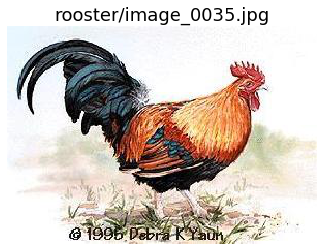

In [32]:
dispay_random_image('rooster')

## VGG16 Arch

![](vgg16.png)

We can see that the image is of dimension (224, 224) in the VGG16 architecture. This means any image we pass through the VGG16 has to be of (224, 224, 3) dimension.

## Get the paths for all the labels

In [33]:
labelPaths = {}
for l in labels:
    labelPaths[l] = dataPath.joinpath(l)

## Preprocess the Images

In [34]:
def preprocess_image(label_path, imageName):
    # Get the path to the image
    image = label_path.joinpath(imageName)
    if not image.exists():
        return None
    # Load the image
    img = cv2.imread(str(image))

    # Reshape the imgage into 224 x 224 x 3
    img_rgb = cv2.resize(img, (224, 224))
    
    # Convert BGR to RGB
    img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
    
    # ImageNet models requires some extra preprocessing
    # For those preprocessing, there should be multiple 3d images
    # But if processing only one, manually add a dimension to make it 4d
    h, w, c = img_rgb.shape
    img_rgb = img_rgb.reshape(-1, h, w, c)
    
    # Finally pass through ImageNet preprocessing
    X = preprocess_input(img_rgb)
    
    # ImageNet returns 4d images back
    # But we need 3d
    return X[0]

In [35]:
img = preprocess_image(labelPaths['rooster'], 'image_0035.jpg')

In [36]:
img.shape

(224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


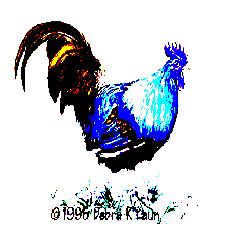

In [37]:
plt.imshow(img);
plt.axis('off');

## OneHotEncoding the class labels

In [38]:
le = LabelEncoder()
labels_le = le.fit_transform(labels)
y = keras.utils.to_categorical(labels_le, num_classes=len(labels))

In [39]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [40]:
y = dict(zip(labels, y))

## Create data and label pairs

```json
    {
        'X': iamge data 4d,
        'y': one hot encoded class label
    }```
        

In [42]:
data = []

In [43]:
for label, lpath in tqdm(labelPaths.items()):
    for img in lpath.iterdir():
        data.append({'X': preprocess_image(img, ''), 'y': y[label]})

In [44]:
len(data)   # Number of data points

6209

## Now shuffle and split data

- 70% Train
- 15% Validation
- 15% Test

In [45]:
random.shuffle(data)  # Shuffles the data
idx_val = int(0.7 * len(data))
idx_test = int((0.7+0.15) * len(data))
train = data[:idx_val]
val = data[idx_val: idx_test]
test = data[idx_test:]

In [46]:
print(f"Length of the training data: {len(train)}")
print(f"Length of the validation data: {len(val)}")
print(f"Length of the testing data: {len(test)}")

Length of the training data: 4346
Length of the validation data: 931
Length of the testing data: 932


## Creating features and labels

In [47]:
X_train = [e['X'] for e in train]
X_train = np.stack(X_train, axis=0)

X_val = [e['X'] for e in val]
X_val = np.stack(X_val, axis=0)

X_test = [e['X'] for e in test]
X_test = np.stack(X_test, axis=0)

In [48]:
X_train.shape

(4346, 224, 224, 3)

In [49]:
X_val.shape

(931, 224, 224, 3)

In [50]:
X_test.shape

(932, 224, 224, 3)

In [51]:
y_train = [e['y'] for e in train]
y_train = np.stack(y_train, axis=0)

y_val = [e['y'] for e in val]
y_val = np.stack(y_val, axis=0)

y_test = [e['y'] for e in test]
y_test = np.stack(y_test, axis=0)

In [52]:
y_train.shape

(4346, 97)

In [53]:
y_val.shape

(931, 97)

In [54]:
y_test.shape

(932, 97)

## Store the datasets

In [55]:
np.save('X_train', X_train)
np.save('X_val', X_val)
np.save('X_test', X_test)

np.save('y_train', y_train)
np.save('y_val', y_val)
np.save('y_test', y_test)

In [56]:
!ls *.npy

X_test.npy  X_train.npy  X_val.npy  y_test.npy	y_train.npy  y_val.npy
